In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2.3

/var/folders/zp/lg_fp2zs1tlg78nx_c4mb91w0000gp/T/ipykernel_47121/3054897577.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  grad_math_df = pd.read_csv(


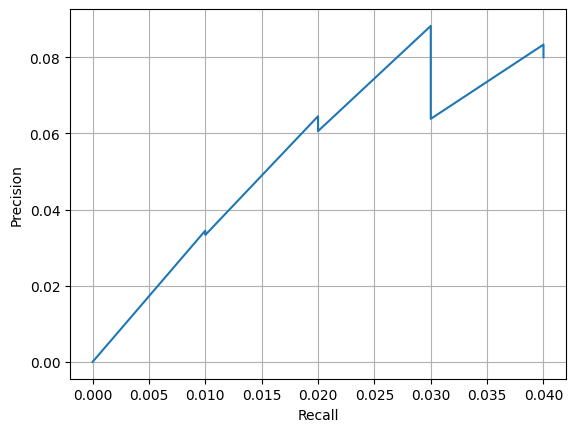

Intersection results:
	 - precision 0.31
	 - recall .07

Ranked retrieval


,Precision,Recall
10,0.000,0.00
20,0.000,0.00
30,0.033,0.01
40,0.075,0.03
50,0.080,0.04


In [198]:

grad_math_df = pd.read_csv(
    "../ratings2.txt",
    delim_whitespace=True,
    index_col=0,
    header=None,
    names=['Index', 'Docname', 'Score'],
    dtype={'Score': int}
)

grad_math_df['relevant'] = grad_math_df['Score'].apply(lambda x: 1 if x > 0 else 0)
grad_math_df['cumsum'] = grad_math_df['relevant'].cumsum()
grad_math_df['precision'] = grad_math_df['cumsum'] / (grad_math_df.index + 1)
grad_math_df['recall'] = grad_math_df['cumsum'] / 100

cutoffs = [9, 19, 29, 39, 49]
metrics_table = grad_math_df.loc[cutoffs, ['precision', 'recall']]
metrics_table.index = [10, 20, 30, 40, 50]
metrics_table.columns = ['Precision', 'Recall']
metrics_table = metrics_table.round(3)

plt.plot(grad_math_df['recall'], grad_math_df['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

print("Intersection results:")
print("\t - precision 0.31")
print("\t - recall .07")

print("\nRanked retrieval")
metrics_table

# 2.6

#### Which of them is better and why?
Euclidean is better both because it has better precision for *zombie attack* and can have a better precision at k = 7 for *money transfer*. 

When normalizing with document length, the scores are biased towards shorter documents rather than document term distribution.

![](2025-02-26-13-45-05.png)

# 2.7

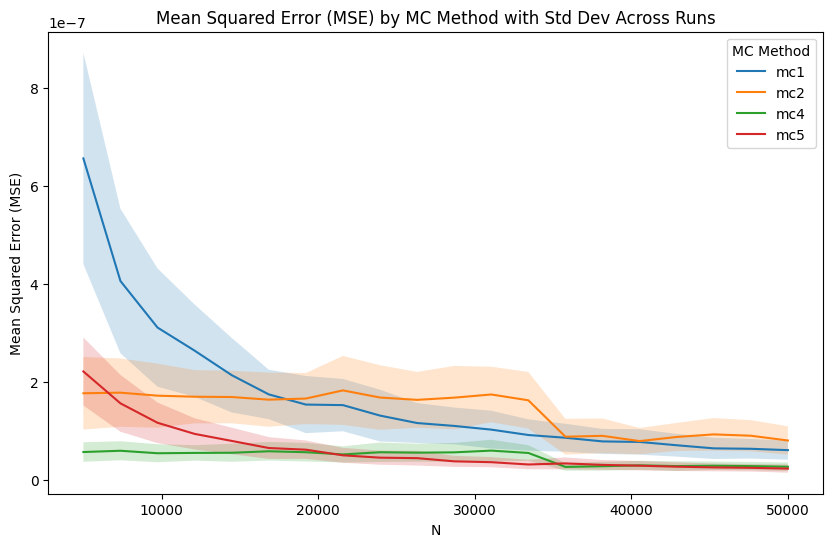

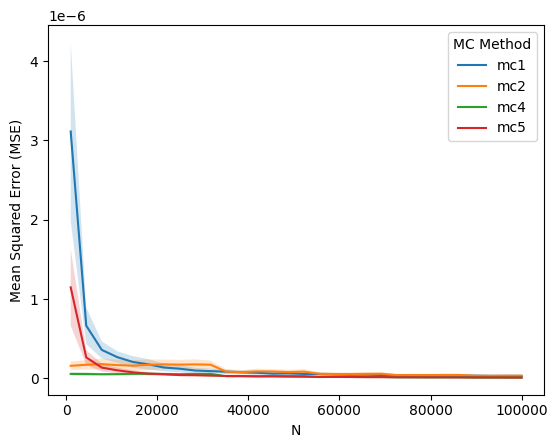

In [199]:
# Load data
mc_df = pd.read_csv('../pagerank/MCranks.txt', header=None, names=['mc', 'N', 'docId', 'PR'])
mc_long_df = pd.read_csv('../pagerank/MCranksLong.txt', header=None, names=['mc', 'N', 'docId', 'PR'])
top_df = pd.read_csv('../pagerank/davis_top_30.txt', delimiter=':', names=['docId', 'PR'])

# Merge with true PageRank
mc_df['PR_true'] = mc_df['docId'].map(top_df.set_index('docId')['PR'])
mc_df['sqrDiff'] = np.square(mc_df['PR'] - mc_df['PR_true'])
mc_long_df['PR_true'] = mc_long_df['docId'].map(top_df.set_index('docId')['PR'])
mc_long_df['sqrDiff'] = np.square(mc_long_df['PR'] - mc_long_df['PR_true'])


# Key Fix: Compute MSE per run (average over documents), then aggregate across runs
# -------------------------------------------------------------------------------
# Add a "run" identifier (assuming each run is a sequential block of 30 rows)
mc_df['run'] = mc_df.groupby(['mc', 'N']).cumcount() // 30  # 30 docs per run
mc_long_df['run'] = mc_long_df.groupby(['mc', 'N']).cumcount() // 30  # 30 docs per run

# Group by mc, N, and run to compute MSE per run
mse_per_run = mc_df.groupby(['mc', 'N', 'run'])['sqrDiff'].mean().reset_index()
mse_long_per_run = mc_long_df.groupby(['mc', 'N', 'run'])['sqrDiff'].mean().reset_index()

# Now compute mean and std of MSE across runs
mc_stats = mse_per_run.groupby(['mc', 'N'])['sqrDiff'].agg(['mean', 'std']).reset_index()
mc_stats.rename(columns={'mean': 'meanMSE', 'std': 'stdMSE'}, inplace=True)

mc_stats_long = mse_long_per_run.groupby(['mc', 'N'])['sqrDiff'].agg(['mean', 'std']).reset_index()
mc_stats_long.rename(columns={'mean': 'meanMSE', 'std': 'stdMSE'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.title('Mean Squared Error (MSE) by MC Method with Std Dev Across Runs')

# Loop through each unique 'mc' to create separate fills
for mc_value in mc_stats['mc'].unique():
# for mc_value in ['mc4']:
    subset = mc_stats[mc_stats['mc'] == mc_value]
    plt.fill_between(
        subset['N'], 
        subset['meanMSE'] - subset['stdMSE'], 
        subset['meanMSE'] + subset['stdMSE'], 
        alpha=0.2
    )
    sns.lineplot(data=subset, x='N', y='meanMSE', label=mc_value)

plt.xlabel('N')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='MC Method')
plt.show()

# Loop through each unique 'mc' to create separate fills
for mc_value in mc_stats_long['mc'].unique():
# for mc_value in ['mc4']:
    subset = mc_stats_long[mc_stats_long['mc'] == mc_value]
    plt.fill_between(
        subset['N'], 
        subset['meanMSE'] - subset['stdMSE'], 
        subset['meanMSE'] + subset['stdMSE'], 
        alpha=0.2
    )
    sns.lineplot(data=subset, x='N', y='meanMSE', label=mc_value)

plt.xlabel('N')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='MC Method')
plt.show()

All claimed to be unbiased estimators, seems true:

algo 2 is argued to reduce variance comp to 1 by using even distribution of starts === YES

algo 4 use full paths and incorporate more information -> reduce variance === YES

algo 5 same start pattern as 1, higher variance === YES

chose 4 due to lowest variance and fast convergence of estimator

# 2.8

#### Unlike PageRank, the HITS method should be run on the fly and only on the query-specific subset of documents. How should one select this subset of documents correctly? 

need a relevant and managebable root set. I use the tf_idf scores to determine the rootset and choose top 10

#### The HITS algorithm provides two scores for each document in the subset, but the search engine can show only one score. How should one combine these two scores in a meaningful way? Can we use a linear combination?

weighted sum:

$$ S(v) = \alpha \cdot A(v) + \beta \cdot H(v)$$

* $A(v)$ is the authority score of document $v$,
 * $H(v)$ is the hub score of document $v$,
 
 * Authorities and hubs are correlated, but authorities are often more relevant for queries.
 * Empirical tuning can improve ranking quality based on query type

# ASSIGNMENT 3

## 3.1

### What happens to the two documents that you selected?

In the **zombie attack** query, document #9 moved up to position #4, and document #2 moved up to position #3.

In the **money transfer** query, document #9 moved up to position #2, and document #8 moved up to position #1.

In the **picnic day davis** query, document #10 moved up to position #4, and document #6 moved up to position #2.

### What are the characteristics of the other documents in the new top ten list - what are they about? Are there any new ones that were not among the top ten before?

Contains a lot of other key words/unqiue words that existed in the other relevant ones.

### Try different values for the weights α and β: How is the relevance feedback process affected by α and β?

High $/alpha$ preserve much of original intent, high $/beta$ is more explorative

### Why is the search after feedback slower? Why is the number of returned documents larger?

Slower because we extend the query with more terms and then for each term we need to calculate the weight. Since we got more terms we will naturally match on more postings


## 3.2

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scores = pd.read_csv("../assignment3/average_relevance_filtered.txt", delimiter=" ", names=['file', 'score'])
before = pd.read_csv("mathTop.txt", delimiter=" ", names=['file'], usecols=[1])
after = pd.read_csv("topRelev.txt", delimiter=" ", names=['file'], usecols=[1])

In [201]:
ideal = scores.sort_values(by=['score'], ascending=False).rename(columns={'score': 'ideal'})['ideal'].values
ideal

array([3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [202]:
before = pd.merge(before, scores, on='file', how='left')
after = pd.merge(after, scores, on='file', how='left')
before['score'] = before['score'].fillna(0)
after['score'] = after['score'].fillna(0)

In [203]:
before['CG'] = before['score'].cumsum()
after['CG'] = after['score'].cumsum()

In [204]:
before['DCG'] = (before['score']/np.log2(np.arange(len(before)) + 2)).cumsum()
after['DCG'] = (after['score']/np.log2(np.arange(len(after)) + 2)).cumsum()

In [205]:
before['ideal'] = ideal[:len(before)]  
before['IDCG'] = (before['ideal']/np.log2(np.arange(len(before)) + 2)).cumsum()
before['NDCG'] = before['DCG']/before['IDCG']

after = after[after['file'] != 'Mathematics.f']
after['ideal'] = ideal[:len(after)]  
after['IDCG'] = (after['ideal']/np.log2(np.arange(len(after)) + 2)).cumsum()
after['NDCG'] = after['DCG']/after['IDCG']

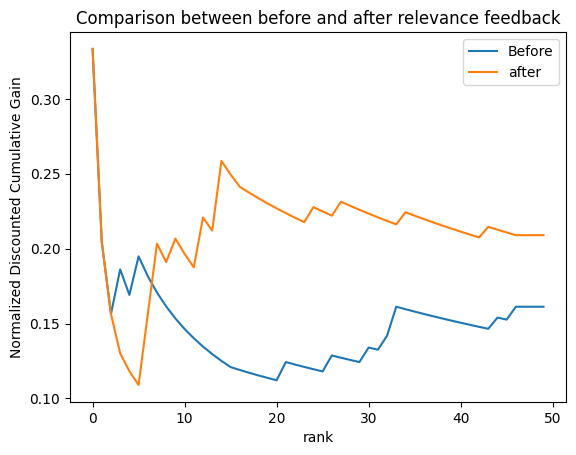

In [206]:
plt.plot(before['NDCG'], label="Before")
plt.plot(after['NDCG'], label="after")
plt.xlabel("rank")
plt.ylabel("Normalized Discounted Cumulative Gain")
plt.legend()
plt.title("Comparison between before and after relevance feedback")
plt.show()

### Why remove?

- remove bias to results
- user has already deemed it relevant want other things